<a href="https://colab.research.google.com/github/bahadirbasaran/pulsarDetection/blob/master/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Environment**

In [0]:
import copy
import multiprocessing
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from warnings import simplefilter
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve, KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, mean_squared_error, cohen_kappa_score, confusion_matrix, classification_report, precision_recall_curve, roc_curve, roc_auc_score, average_precision_score
from sklearn.exceptions import FitFailedWarning
simplefilter("ignore", UserWarning)
simplefilter("ignore", FutureWarning)
simplefilter("ignore", FitFailedWarning)

**Function&Class Definitions**

In [0]:
def plot_2D_space(X, y, label='Classes'):   
  colors = ['#1F77B4', '#FF7F0E']
  markers = ['o', 's']
  for l, c, m in zip(np.unique(y), colors, markers):
    plt.scatter(X[y==l, 0], X[y==l, 1], c=c, label=l, marker=m)
  plt.title(label, fontsize=16)
  plt.legend(loc='upper right')
  plt.show()

def plot_roc_curve(classifier, y_true, probabilities):
  false_positive_rate, true_positive_rate, thresholds = roc_curve(y_true, probabilities)
  score_roc_auc = roc_auc_score(y_true, probabilities)
  plt.figure(figsize=(10,5))
  plt.plot(false_positive_rate, true_positive_rate, color='orange', label=('AUC Score: ', "%.3f" % score_roc_auc))
  plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC Curve of {}'.format(classifier), fontsize=16)
  plt.legend(loc='best')
  plt.show()

def plot_precision_recall_curve(classifier, y_true, y_pred, probabilities):
  score_avg_precision = "%.3f" % average_precision_score(y_true, y_pred)
  precisions, recalls, thresholds = precision_recall_curve(y_true, probabilities)
  plt.figure(figsize=(10,5))
  plt.plot(recalls, precisions, marker='.', label=classifier)
  plt.title("{} Average Precision: {}".format(classifier, score_avg_precision), fontsize=16)
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.legend(loc='best')
  plt.show()

def plot_confusion_matrix(classifier, y_true, y_pred):
  plt.figure(figsize=(10,5))
  sb.heatmap(confusion_matrix(y_true,y_pred),annot=True,fmt = "d",linecolor="k",linewidths=3)
  plt.title("Confusion Matrix of {}".format(classifier), fontsize=16)
  plt.show()

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
  plt.figure(figsize=(10,5))
  plt.title(title, fontsize=16)
  if ylim is not None:
    plt.ylim(*ylim)
  plt.xlabel("Training Examples")
  plt.ylabel("Score")
  train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
  train_scores_mean = np.mean(train_scores, axis=1)
  train_scores_std = np.std(train_scores, axis=1)
  test_scores_mean = np.mean(test_scores, axis=1)
  test_scores_std = np.std(test_scores, axis=1)
  plt.grid()

  plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
  plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
  plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training Score")
  plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation Score")
  plt.legend(loc="best")
  plt.show()

def plot_feature_importances(estimator, data):
  plt.figure(figsize=(10,5))
  featureImportances = pd.Series(estimator.feature_importances_, index=data.columns[:-1]).sort_values(ascending=False)
  sb.barplot(x=featureImportances, y=featureImportances.index)
  plt.title('Feature Importances', fontsize=16)
  plt.xlabel('Score')
  plt.show()

def evaluateClassifier(classifier, y_true, y_pred, probabilities, df_stats):  
  score_acc = accuracy_score(y_true,y_pred)
  print("\nAccuracy Score of {}: {}".format(classifier, "%.3f" % score_acc))

  score_mse = mean_squared_error(y_true, y_pred)
  print("\nMean Squared Error Score of {}: {}".format(classifier, "%.3f" % score_mse))

  score_cohenKappa = cohen_kappa_score(y_true, y_pred)
  print("\nCohen Kappa Score of {}: {}".format(classifier, "%.3f" % score_cohenKappa))

  classificationReport = classification_report(y_true, y_pred)
  print("\nClassification Report of {}:\n\n{}".format(classifier, classificationReport))

  plot_confusion_matrix(classifier, y_true, y_pred)

  plot_roc_curve(classifier, y_true, probabilities)

  plot_precision_recall_curve(classifier, y_true, y_pred, probabilities)

  df_stats = df_stats.append({"Model":classifier, "Accuracy":score_acc, "MSE":score_mse, "Cohen Kappa Score":score_cohenKappa}, ignore_index=True)
  return df_stats

def createDataSplits(dataset, list_dataColumns, targetColumn, testSizeRatio, randomState=42, oversample=True, normalize=True):   
  X = dataset[dataset.columns[list_dataColumns]]
  y = dataset[dataset.columns[targetColumn]]
    
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = testSizeRatio, random_state=randomState)
    
  if normalize == True:
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
        
  #Index of X_train and X_test are changed. We must reset the index of y_train and y_test.Otherwise, index mismatch error.
  y_train = y_train.reset_index(drop=True)
  y_test = y_test.reset_index(drop=True)

  #Oversampling to balance the data set        
  if oversample == True:
    sm = SMOTE(sampling_strategy='minority', random_state=randomState)
    X_train, y_train = sm.fit_sample(X_train, y_train)   
    plot_2D_space(X_train, y_train, label='Dataset After Oversampling')  

  return X_train, X_test, y_train, y_test

**Data Importation**

In [0]:
dataset = pd.read_csv('https://raw.githubusercontent.com/bahadirbasaran/pulsarDetection/master/pulsar_stars.csv')

**Data Visualization**

Dataset Summary:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17898 entries, 0 to 17897
Data columns (total 9 columns):
 Mean of the integrated profile                  17898 non-null float64
 Standard deviation of the integrated profile    17898 non-null float64
 Excess kurtosis of the integrated profile       17898 non-null float64
 Skewness of the integrated profile              17898 non-null float64
 Mean of the DM-SNR curve                        17898 non-null float64
 Standard deviation of the DM-SNR curve          17898 non-null float64
 Excess kurtosis of the DM-SNR curve             17898 non-null float64
 Skewness of the DM-SNR curve                    17898 non-null float64
target_class                                     17898 non-null int64
dtypes: float64(8), int64(1)
memory usage: 1.2 MB


Correlation Matrix Heatmap:




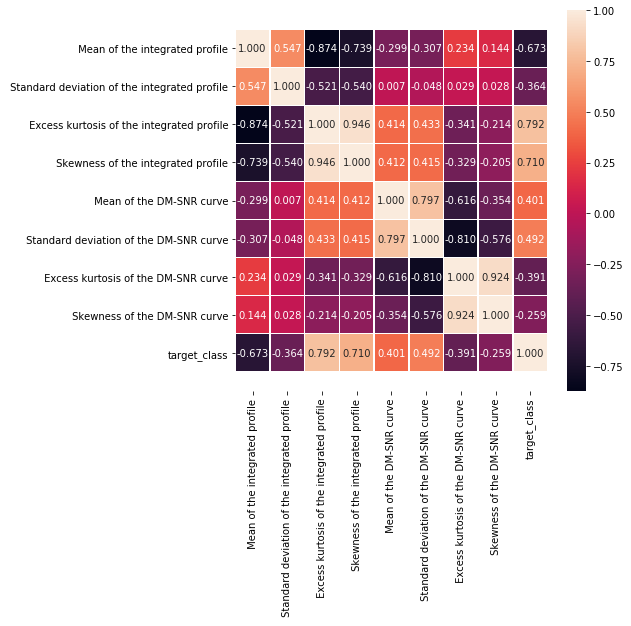



Distribution Plot:



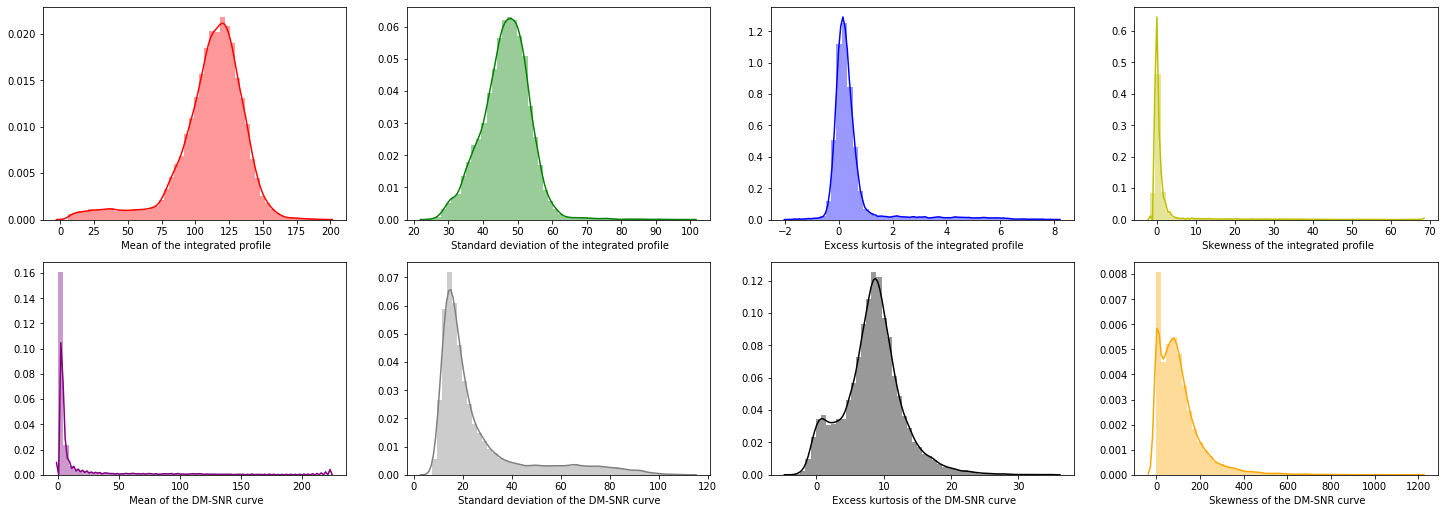



Pair Plot:




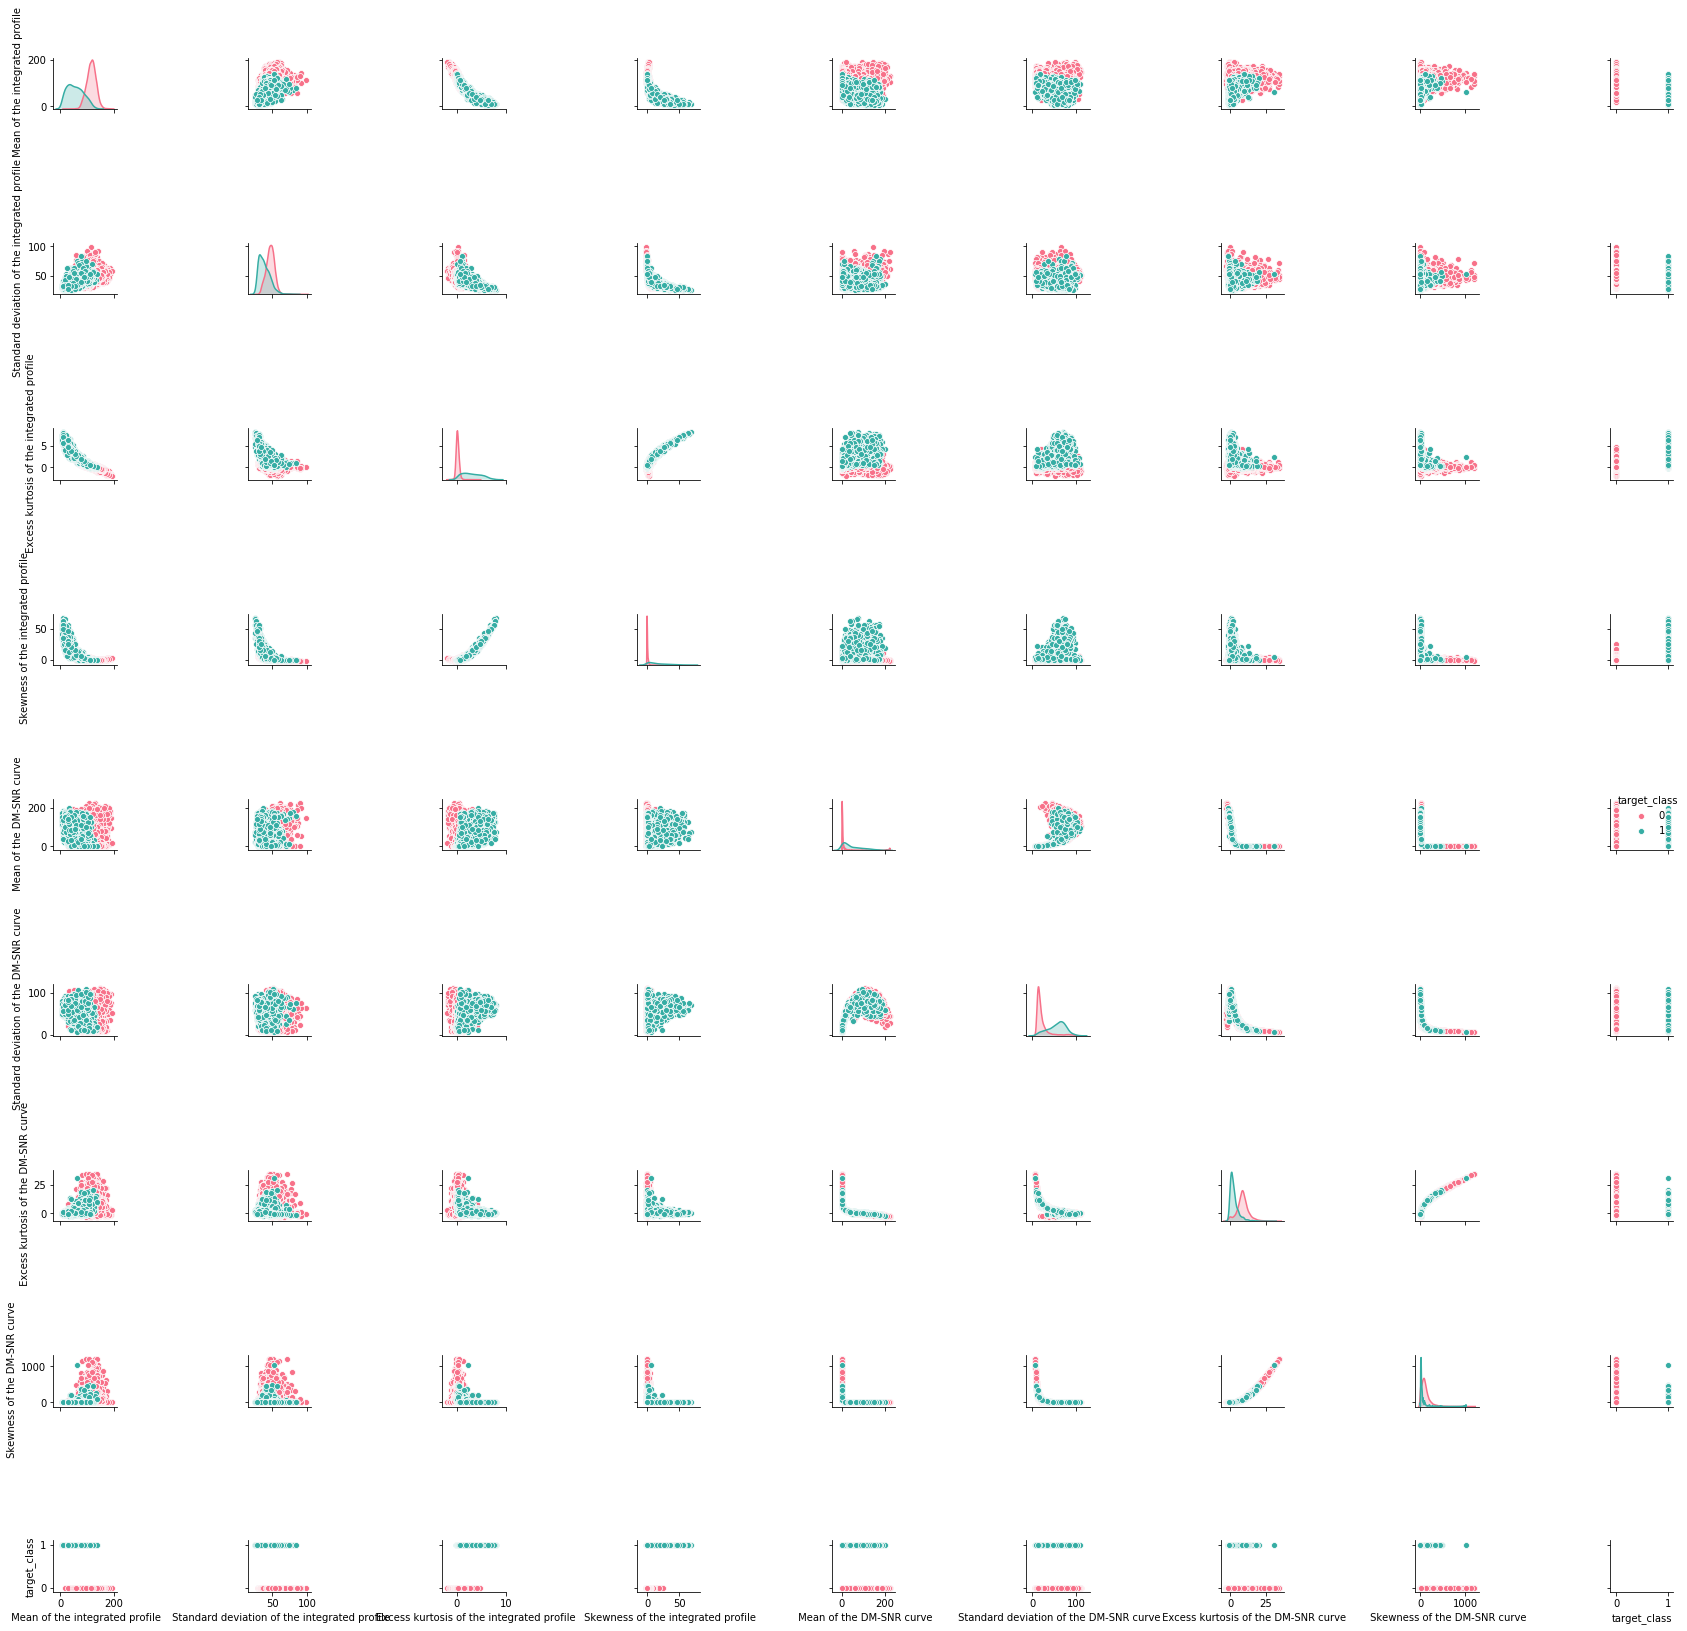



Violin Plot:




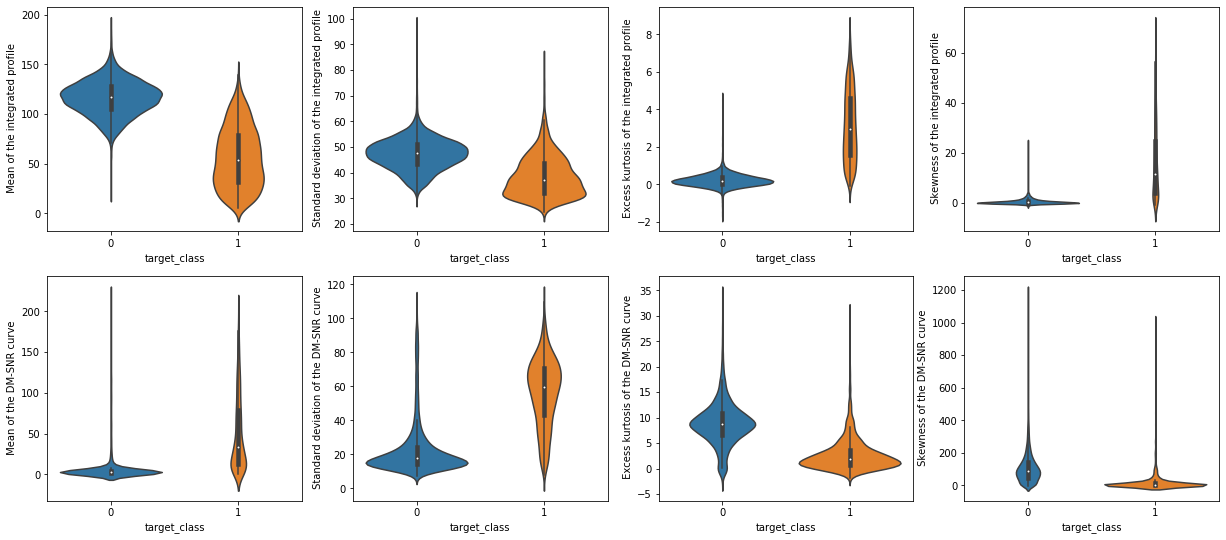



Bar Plot:




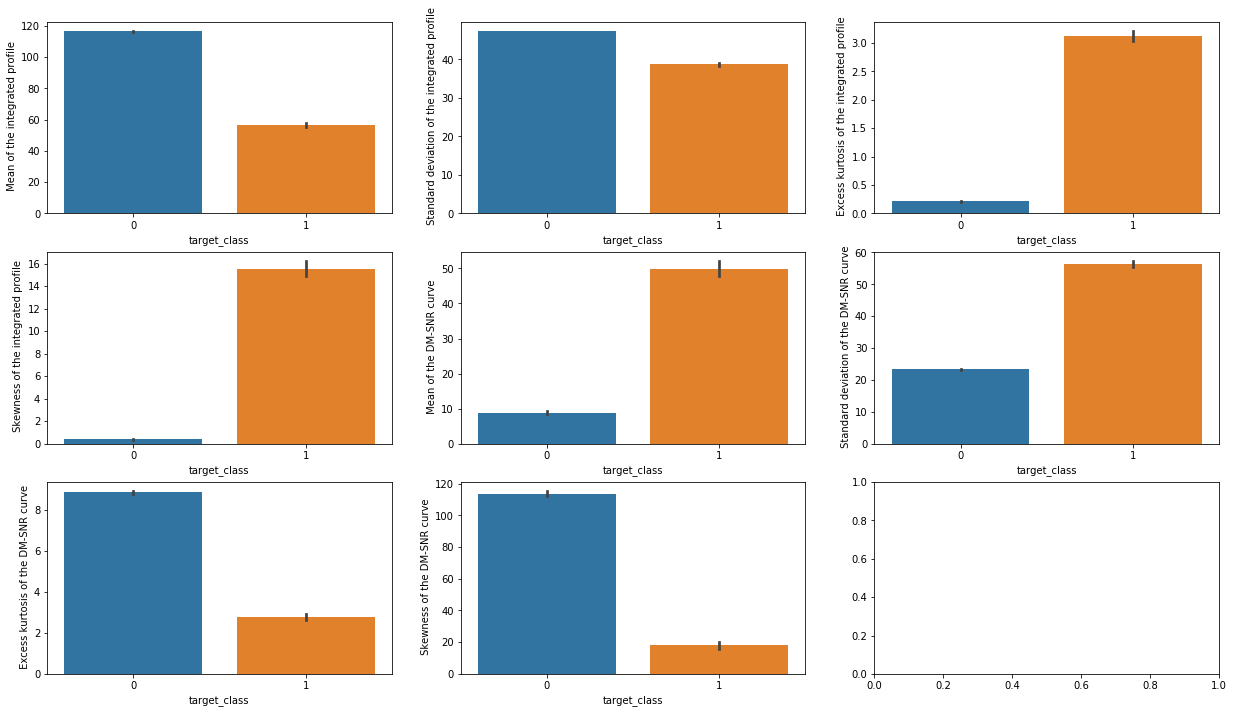



Joint Plot:



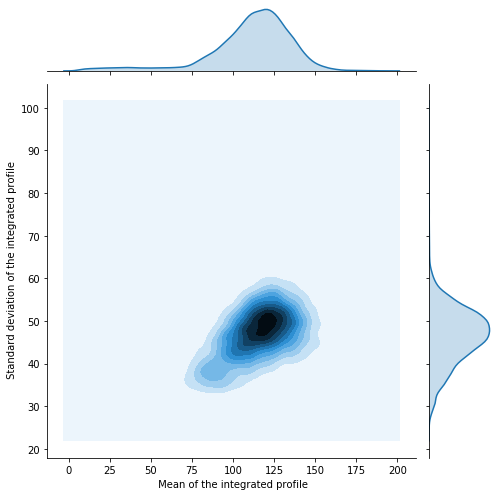

In [23]:
print("Dataset Summary:\n")
dataset.info()
datasetStats = dataset.describe()

# Correlation Matrix Heatmap
print("\n\nCorrelation Matrix Heatmap:\n\n")
_, ax = plt.subplots(figsize = (7,7))
hm = sb.heatmap(dataset.corr(), annot = True, linewidths=.5, fmt = ".3f", ax=ax)
bottom, top = hm.get_ylim()
hm.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

# Dist Plot
print("\n\nDistribution Plot:\n")
plt.figure(figsize=(25,18))
for i, column, color in zip(list(range(0,8)), dataset.columns[:-1], ['r', 'g', 'b', 'y', 'purple', 'grey', 'black', 'orange']):
    plt.subplot(4,4,i+1)
    sb.distplot(dataset[column], color=color)        
plt.show()

# Pair Plot
print("\n\nPair Plot:\n\n")
sb.pairplot(data=dataset,
             palette="husl",
             hue="target_class",
             vars=list(dataset.columns))
plt.tight_layout()
plt.show()

# Violin Plot
print("\n\nViolin Plot:\n\n")
plt.figure(figsize=(21,19))
for i in range(8):
    plt.subplot(4,4,i+1)
    sb.violinplot(data=dataset, y=dataset.columns[i], x="target_class")
plt.show()

# Bar Plot
print("\n\nBar Plot:\n\n")
_, ax1 = plt.subplots(3,3, figsize=(21,12))
k = 0
for i in range(3):
    for j in range(3):
        if k != 8:
            sb.barplot(x='target_class', y=dataset.columns[k], data=dataset, ax = ax1[i][j])
            k += 1            
plt.show()

# Joint Plot
print("\n\nJoint Plot:\n")
sb.jointplot(x=dataset.columns[0], y=dataset.columns[1], data=dataset, kind='kde', height=7)
plt.show()

**Data Splits**

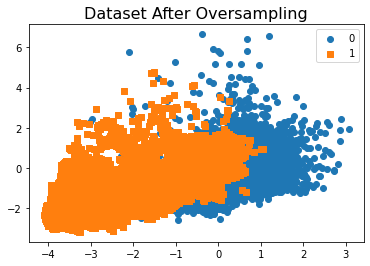

In [11]:
X_train, X_test, y_train, y_test = createDataSplits(dataset, [0,1,2,3,4,5,6,7], 8, 0.3)


# **Model Execution&Evaluation**

**Model Preparation**

In [0]:
params_LR =   {"penalty": ['none', 'l2'], 'C': [0.01, 0.1, 1, 10, 100, 1000]}
params_kNN =  {"n_neighbors": [3, 5, 7, 9, 11, 13, 15], "weights": ['uniform', 'distance']}
params_SVC =  {'C': [10, 100, 1000], 'gamma': [1.0/500.0, 1.0/750.0], 'kernel': ['rbf', 'poly'], 'probability': [True], 'max_iter': [2000]}
params_DT =   {"criterion": ["gini", "entropy"], "max_depth": [1, 2, None], "min_samples_leaf": [1, 2, 3]}
params_RF =   {"n_estimators": [300], "criterion": ["gini", "entropy"], "max_depth": [1, 2, None], "min_samples_leaf": [1, 2, 3]}
params_AB =   {"n_estimators": [300]}
params_GB =   {"n_estimators": [300], "loss": ['deviance', 'exponential'], "learning_rate": [0.05, 0.1], "max_depth": [1, 2, 3], "min_samples_leaf": [1, 2, 3]}
params_XGB =  {"n_estimators": [300], "eta": [0.05, 0.1]}
params_ET =   {"n_estimators": [300], "criterion": ["gini", "entropy"], "max_depth": [1, 2, None]}

list_paramSets = [params_LR, params_kNN, params_SVC, params_DT, params_RF, params_AB, params_GB, params_XGB, params_ET]

list_classifiers = [LogisticRegression(), KNeighborsClassifier(), SVC(), DecisionTreeClassifier(), RandomForestClassifier(),
                    AdaBoostClassifier(), GradientBoostingClassifier(), XGBClassifier(), ExtraTreeClassifier()]

list_clfNames = ["Logistic Regression", "k-Nearest Neighbors", "Support Vector Machines", "Decision Tree",
                 "Random Forest", "AdaBoost", "Gradient Boosting", "XGBoost", "Extra Tree"]

dataframe_stats = pd.DataFrame(columns=['Model', 'Accuracy', 'MSE', 'Cohen Kappa Score'])

**Model Execution**


Naive Bayes Average Score of Training Folds: 0.902 +/- 0.010

Accuracy Score of Naive Bayes: 0.941

Mean Squared Error Score of Naive Bayes: 0.059

Cohen Kappa Score of Naive Bayes: 0.695

Classification Report of Naive Bayes:

              precision    recall  f1-score   support

           0       0.99      0.95      0.97      4884
           1       0.62      0.88      0.73       486

    accuracy                           0.94      5370
   macro avg       0.80      0.91      0.85      5370
weighted avg       0.95      0.94      0.95      5370



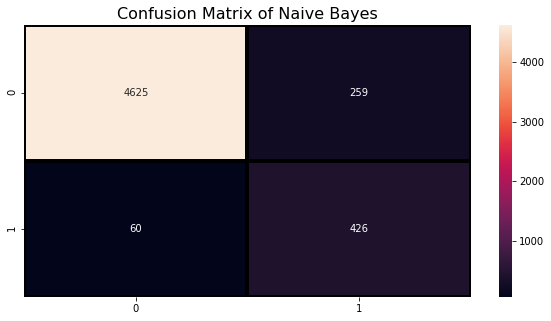

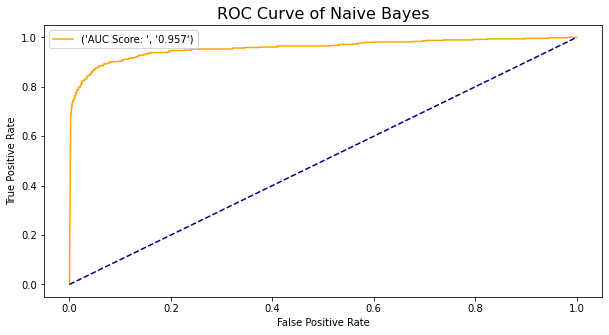

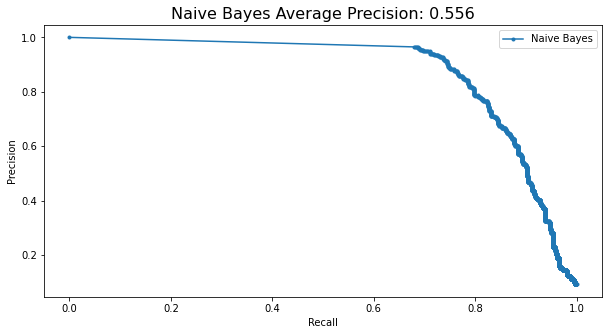

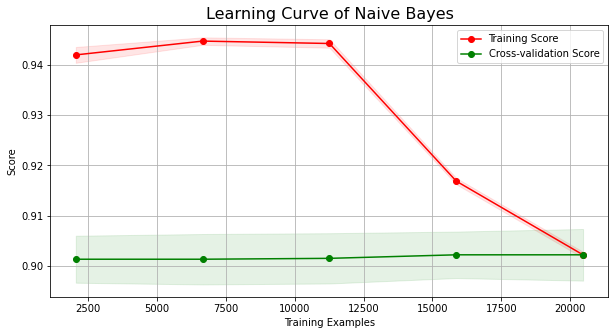


Logistic Regression Average Score of Training Folds: 0.943

Logistic Regression Best Parameters Set:

	Parameter penalty: l2
	Parameter C: 10

Accuracy Score of Logistic Regression: 0.970

Mean Squared Error Score of Logistic Regression: 0.030

Cohen Kappa Score of Logistic Regression: 0.828

Classification Report of Logistic Regression:

              precision    recall  f1-score   support

           0       0.99      0.98      0.98      4884
           1       0.78      0.92      0.85       486

    accuracy                           0.97      5370
   macro avg       0.89      0.95      0.91      5370
weighted avg       0.97      0.97      0.97      5370



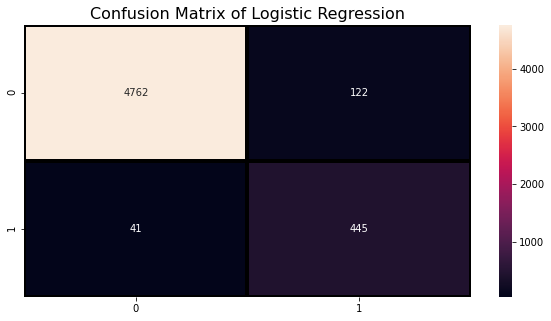

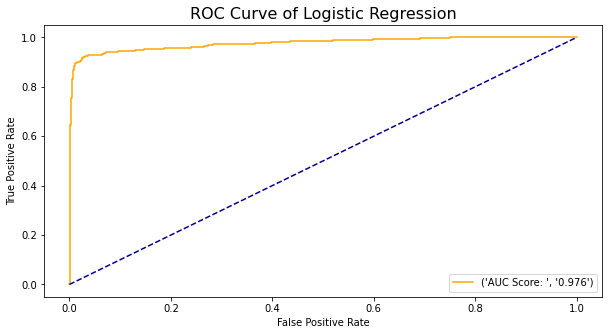

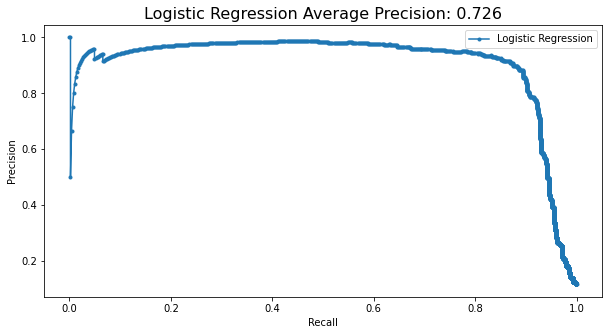

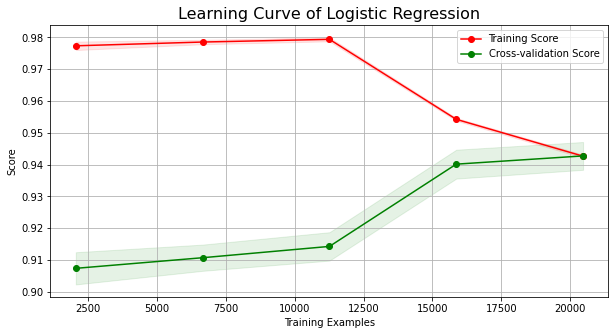


k-Nearest Neighbors Average Score of Training Folds: 0.974

k-Nearest Neighbors Best Parameters Set:

	Parameter n_neighbors: 3
	Parameter weights: distance

Accuracy Score of k-Nearest Neighbors: 0.950

Mean Squared Error Score of k-Nearest Neighbors: 0.050

Cohen Kappa Score of k-Nearest Neighbors: 0.740

Classification Report of k-Nearest Neighbors:

              precision    recall  f1-score   support

           0       0.99      0.96      0.97      4884
           1       0.67      0.90      0.77       486

    accuracy                           0.95      5370
   macro avg       0.83      0.93      0.87      5370
weighted avg       0.96      0.95      0.95      5370



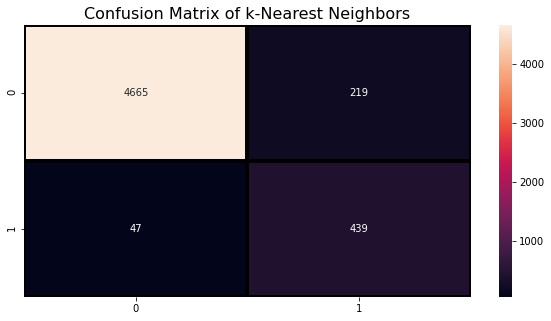

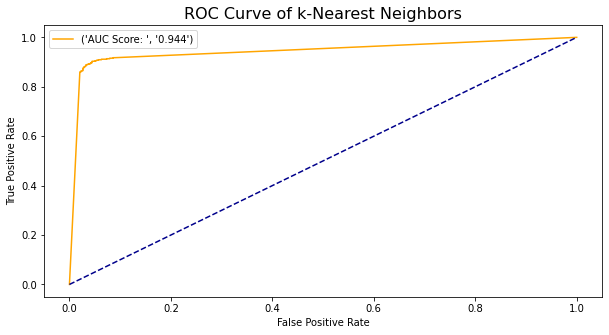

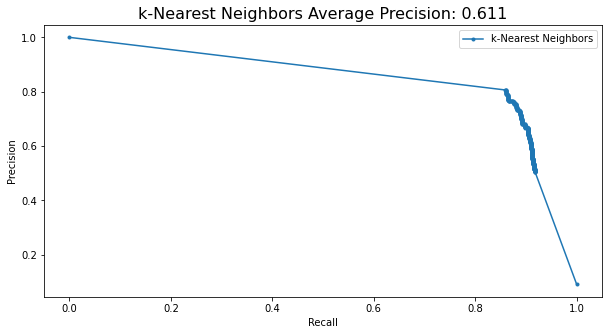

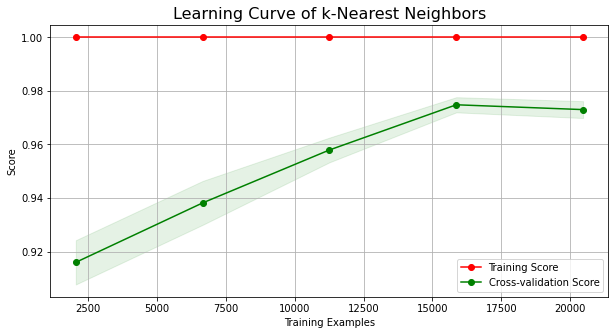


Support Vector Machines Average Score of Training Folds: 0.946

Support Vector Machines Best Parameters Set:

	Parameter C: 100
	Parameter gamma: 0.0013333333333333333
	Parameter kernel: rbf
	Parameter probability: True
	Parameter max_iter: 2000

Accuracy Score of Support Vector Machines: 0.924

Mean Squared Error Score of Support Vector Machines: 0.076

Cohen Kappa Score of Support Vector Machines: 0.648

Classification Report of Support Vector Machines:

              precision    recall  f1-score   support

           0       0.99      0.92      0.96      4884
           1       0.55      0.93      0.69       486

    accuracy                           0.92      5370
   macro avg       0.77      0.93      0.82      5370
weighted avg       0.95      0.92      0.93      5370



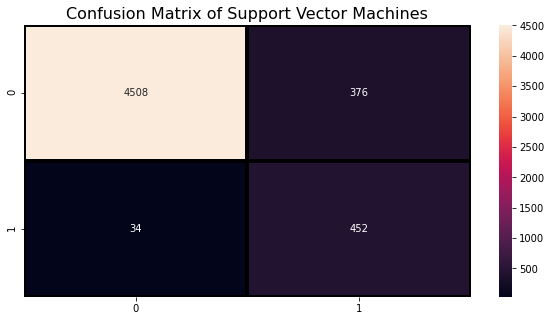

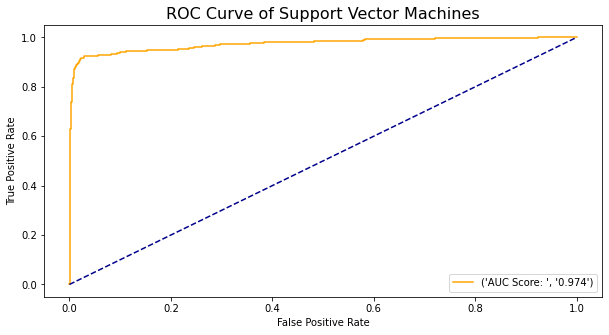

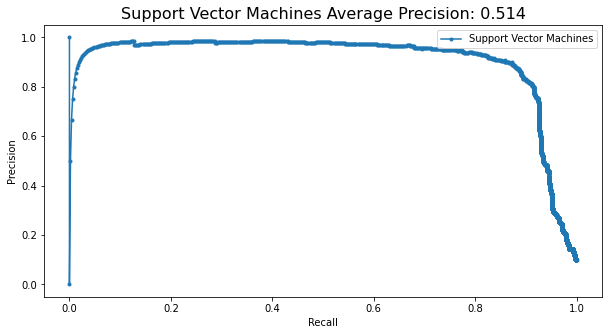

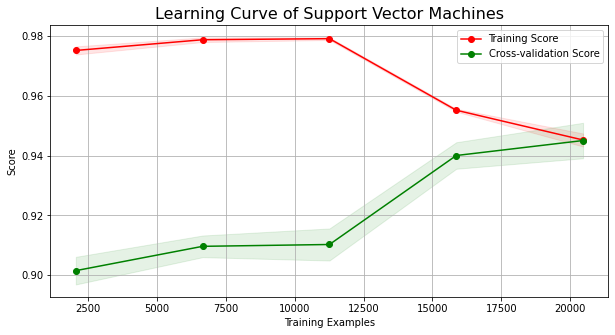


Decision Tree Average Score of Training Folds: 0.962

Decision Tree Best Parameters Set:

	Parameter criterion: entropy
	Parameter max_depth: None
	Parameter min_samples_leaf: 1

Accuracy Score of Decision Tree: 0.950

Mean Squared Error Score of Decision Tree: 0.050

Cohen Kappa Score of Decision Tree: 0.735

Classification Report of Decision Tree:

              precision    recall  f1-score   support

           0       0.99      0.96      0.97      4884
           1       0.67      0.88      0.76       486

    accuracy                           0.95      5370
   macro avg       0.83      0.92      0.87      5370
weighted avg       0.96      0.95      0.95      5370



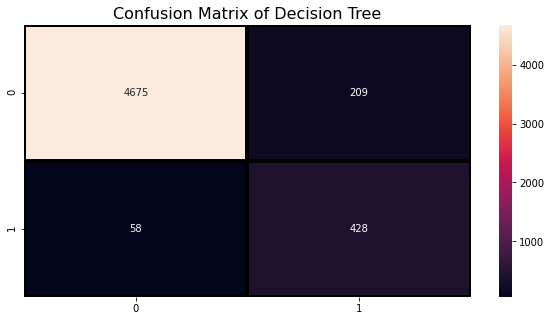

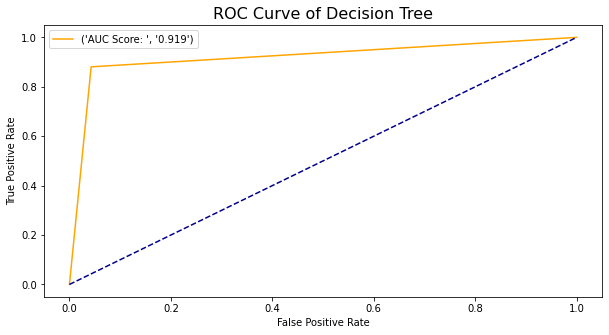

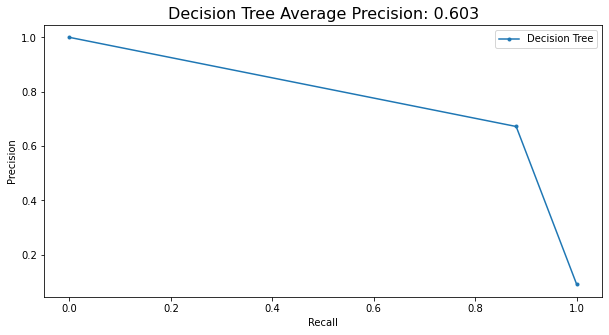

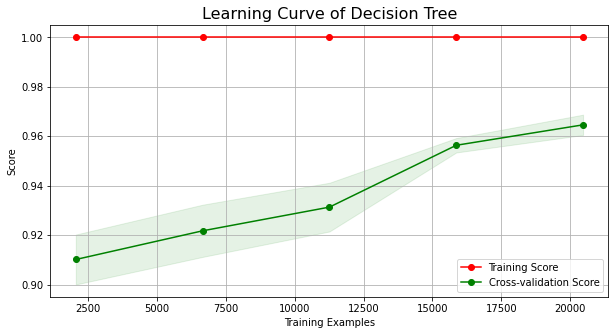

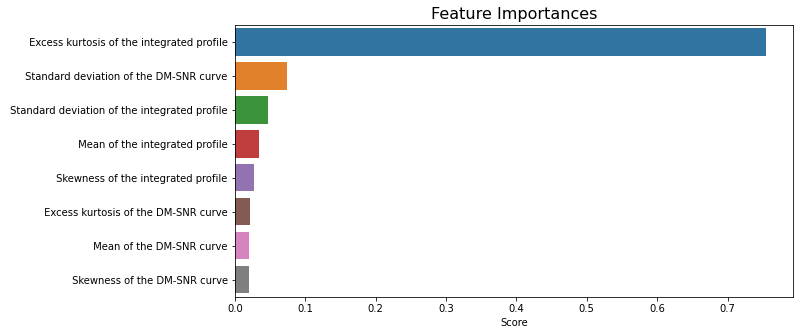


Random Forest Average Score of Training Folds: 0.978

Random Forest Best Parameters Set:

	Parameter n_estimators: 300
	Parameter criterion: entropy
	Parameter max_depth: None
	Parameter min_samples_leaf: 1

Accuracy Score of Random Forest: 0.976

Mean Squared Error Score of Random Forest: 0.024

Cohen Kappa Score of Random Forest: 0.856

Classification Report of Random Forest:

              precision    recall  f1-score   support

           0       0.99      0.98      0.99      4884
           1       0.84      0.90      0.87       486

    accuracy                           0.98      5370
   macro avg       0.92      0.94      0.93      5370
weighted avg       0.98      0.98      0.98      5370



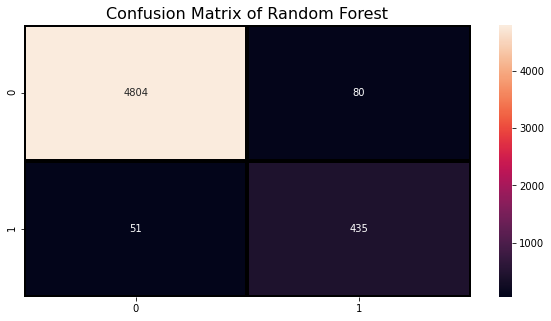

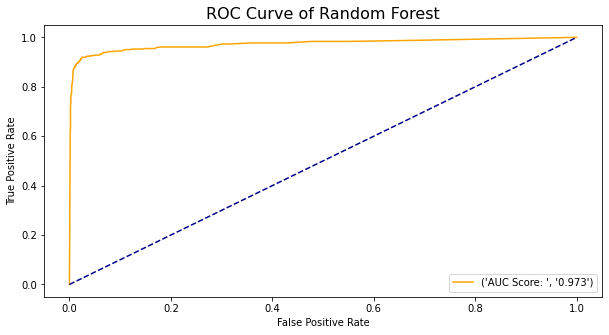

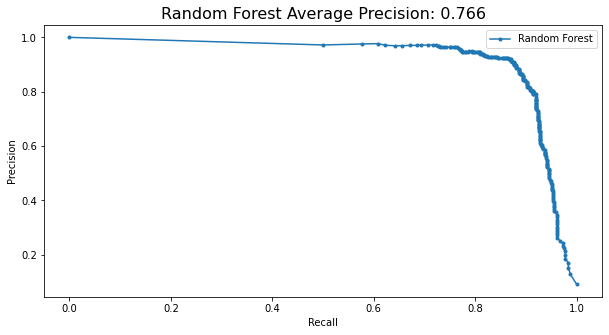

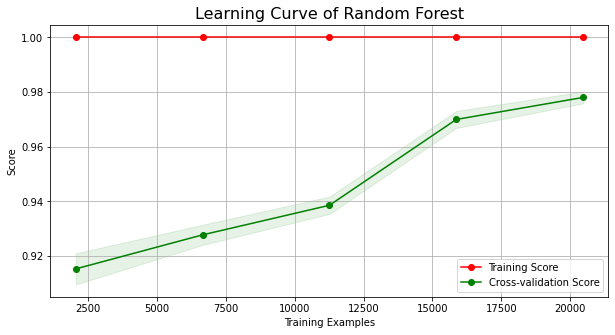

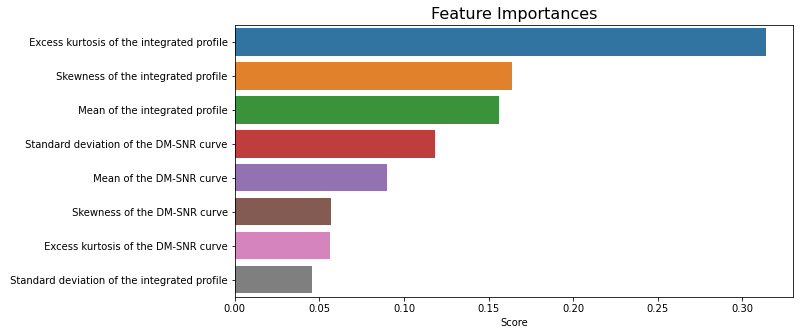


AdaBoost Average Score of Training Folds: 0.963

AdaBoost Best Parameters Set:

	Parameter n_estimators: 300
	Parameter base_estimator: DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

Accuracy Score of AdaBoost: 0.953

Mean Squared Error Score of AdaBoost: 0.047

Cohen Kappa Score of AdaBoost: 0.745

Classification Report of AdaBoost:

              precision    recall  f1-score   support

           0       0.99      0.96      0.97      4884
           1       0.69      0.88      0.77       486

    accuracy                           0.95      5370
   macro avg       0.84      0.92      0.87      5370
weight

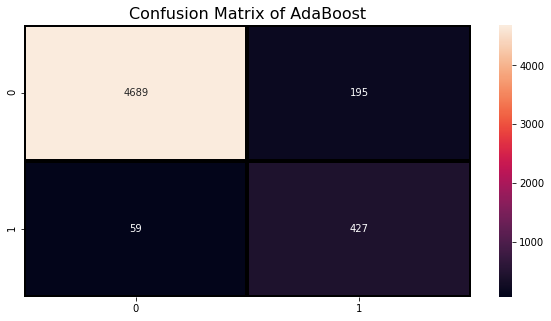

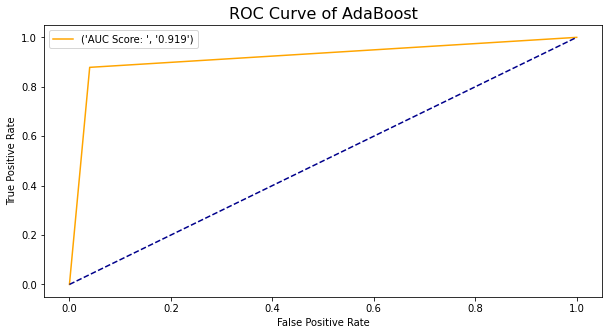

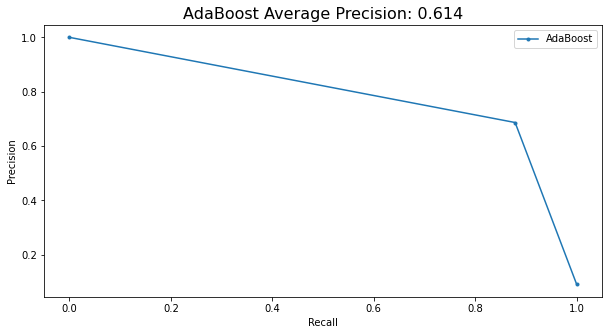

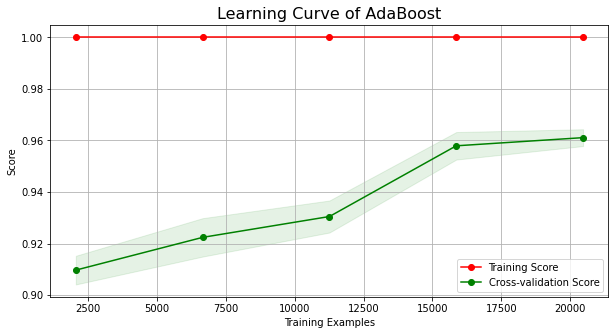

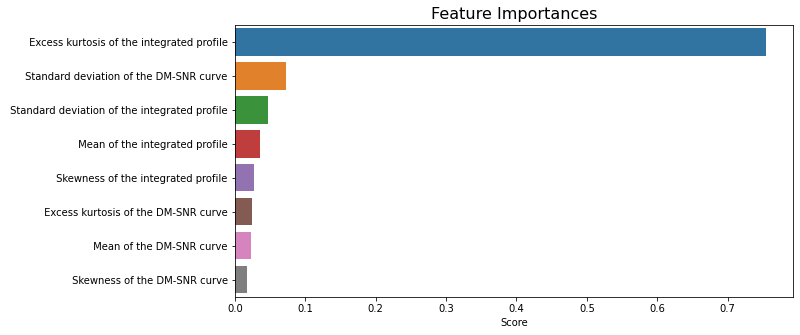


Gradient Boosting Average Score of Training Folds: 0.957

Gradient Boosting Best Parameters Set:

	Parameter n_estimators: 300
	Parameter loss: deviance
	Parameter learning_rate: 0.1
	Parameter max_depth: 3
	Parameter min_samples_leaf: 3

Accuracy Score of Gradient Boosting: 0.967

Mean Squared Error Score of Gradient Boosting: 0.033

Cohen Kappa Score of Gradient Boosting: 0.818

Classification Report of Gradient Boosting:

              precision    recall  f1-score   support

           0       0.99      0.97      0.98      4884
           1       0.77      0.92      0.84       486

    accuracy                           0.97      5370
   macro avg       0.88      0.95      0.91      5370
weighted avg       0.97      0.97      0.97      5370



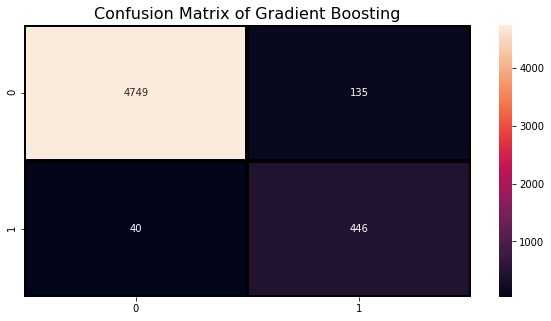

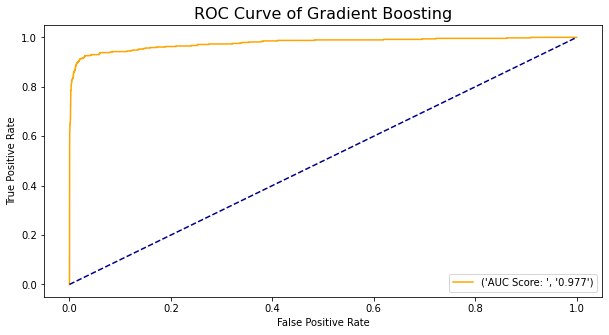

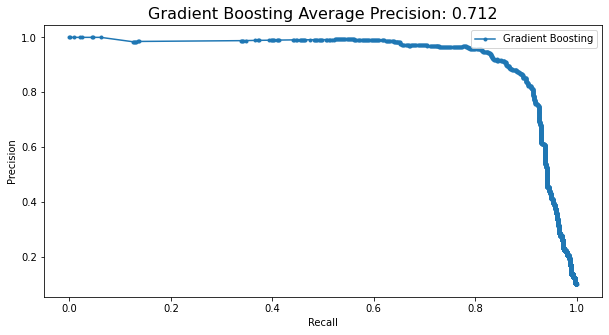

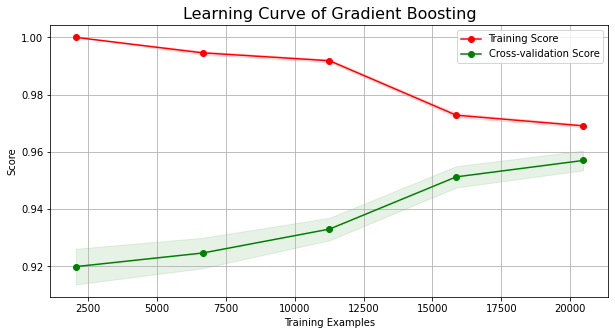

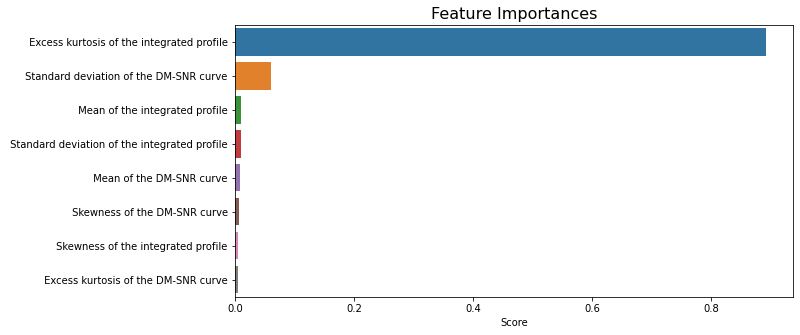


XGBoost Average Score of Training Folds: 0.957

XGBoost Best Parameters Set:

	Parameter n_estimators: 300
	Parameter eta: 0.05

Accuracy Score of XGBoost: 0.965

Mean Squared Error Score of XGBoost: 0.035

Cohen Kappa Score of XGBoost: 0.806

Classification Report of XGBoost:

              precision    recall  f1-score   support

           0       0.99      0.97      0.98      4884
           1       0.75      0.92      0.83       486

    accuracy                           0.96      5370
   macro avg       0.87      0.94      0.90      5370
weighted avg       0.97      0.96      0.97      5370



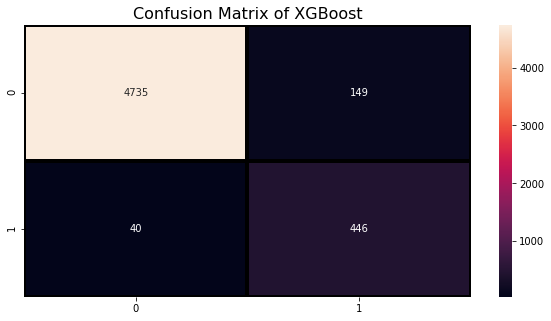

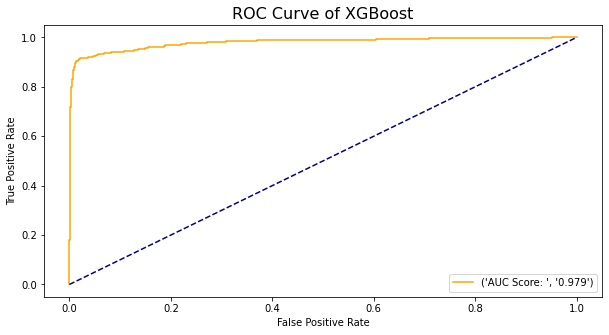

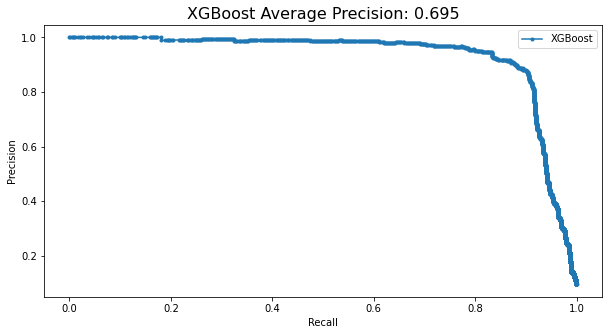

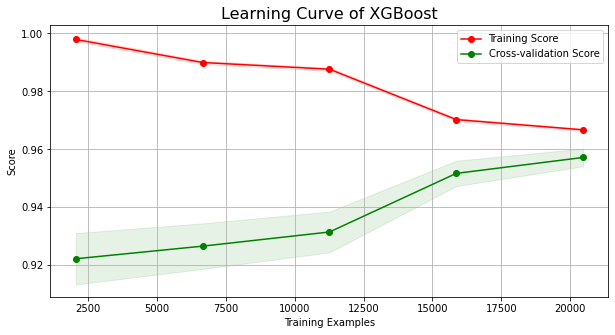

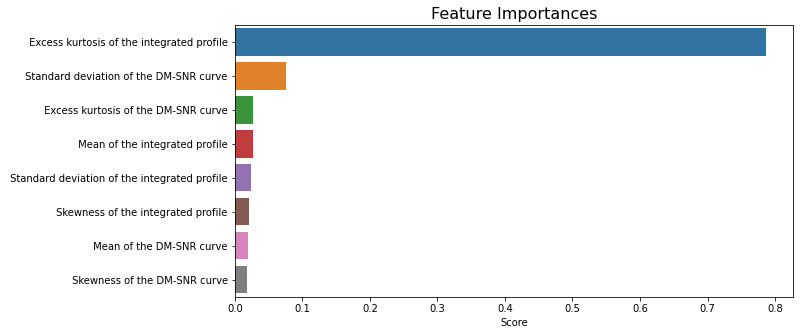

ValueError: ignored

In [12]:
# We cannot use Naive Bayes Classifier with GridSearchCV
clf_NB = GaussianNB() 

foldScores = cross_val_score(clf_NB, X_train, y_train, cv=10)

clf_NB.fit(X_train, y_train)

y_pred = clf_NB.predict(X_test)
probs = clf_NB.predict_proba(X_test)[:, 1]

print("\nNaive Bayes Average Score of Training Folds: {} +/- {}".format("%.3f" % foldScores.mean(), "%.3f" % (foldScores.std() * 2)))

dataframe_stats = evaluateClassifier("Naive Bayes", y_test, y_pred, probs, dataframe_stats)

cv = KFold(n_splits=10, shuffle=True)
plot_learning_curve(clf_NB, "Learning Curve of Naive Bayes", X_train, y_train, cv=cv)

for classifier, paramSet, classifierName in zip(list_classifiers, list_paramSets, list_clfNames):
  gs = GridSearchCV(
                    estimator = classifier,
                    param_grid = paramSet,
                    cv = 10              
                   )
  gs.fit(X_train, y_train)

  #Best estimator that is the result of DecisionTreeClassifier will be used in AdaBoost
  if classifierName == "Decision Tree":
    params_AB.update({"base_estimator": [gs.best_estimator_]})

  print("\n{} Average Score of Training Folds: {}".format(classifierName, "%.3f" % gs.best_score_))
  print("\n{} Best Parameters Set:\n".format(classifierName))
  for param in paramSet.keys():
    print("\tParameter {}: {}".format(param, gs.best_estimator_.get_params()[param]))

  y_pred = gs.best_estimator_.predict(X_test)

  #Predict probabilities for the test data and Keep Probabilities of the positive class only.
  probs = gs.best_estimator_.predict_proba(X_test)[:, 1]

  dataframe_stats = evaluateClassifier(classifierName, y_test, y_pred, probs, dataframe_stats)

  cv = KFold(n_splits=10, shuffle=True)
  title = "Learning Curve of " + classifierName
  plot_learning_curve(gs.best_estimator_, title, X_train, y_train, cv=cv)

  #If a classifier belongs to the list below, in order to draw the feature importances:
  if classifierName in ["Decision Tree", "Random Forest", "AdaBoost", "Gradient Boosting", "XGBoost", "Extra Tree"]:
    plot_feature_importances(gs.best_estimator_, dataset)

**Model Evaluation**

In [0]:
#Listing the results
dataframe_stats.sort_values(by='Accuracy', ascending=False)
print(dataframe_stats)